In [7]:
%pip install pycryptodome kyber_py seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 5.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /usr/local/Cellar/jupyterlab/4.3.6/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
%pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 4.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /usr/local/Cellar/jupyterlab/4.3.6/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import time
import numpy as np
from PIL import Image, PngImagePlugin
import struct
from hashlib import shake_256
from Crypto.Hash import HMAC, SHA3_512, SHA3_256
from Crypto.Random import get_random_bytes
from kyber_py.kyber import Kyber1024
from scipy.stats import pearsonr, entropy
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [2]:
class SecurityAnalyzer:
    @staticmethod
    def information_entropy(image_path: str) -> float:
        """
        Calculate the entropy of a grayscale image.
        """
        # Load the image and convert to grayscale if necessary
        with Image.open(image_path) as img:
            if img.mode != 'L':  # Convert to grayscale if not already
                img = img.convert('L')
            pixels = np.array(img).flatten()  # Flatten to 1D array
    
        # Calculate histogram and probabilities
        histogram = np.bincount(pixels, minlength=256)  # Count occurrences of each pixel value (0-255)
        probabilities = histogram / len(pixels)  # Normalize to get probabilities
    
        # Remove zero probabilities to avoid log2(0)
        probabilities = probabilities[probabilities > 0]

        # Calculate entropy
        entropy = -np.sum(probabilities * np.log2(probabilities))

        return float(entropy)

    @staticmethod
    def correlation_coefficients(image_data: bytes, width: int, height: int, channels: int) -> dict:
        """Calculate correlations with proper channel handling"""
        try:
            if channels == 1:
                arr = np.frombuffer(image_data, dtype=np.uint8).reshape(height, width)
            else:
                arr = np.frombuffer(image_data, dtype=np.uint8).reshape(height, width, channels)
        except ValueError as e:
            expected_size = height * width * channels
            raise ValueError(
                f"Image reshape error: {e}\n"
                f"Expected {expected_size} bytes, got {len(image_data)}\n"
                f"Channels: {channels}, Dimensions: {width}x{height}"
            ) from e

        pairs = 2000
        h, v, d = [], [], []

        for _ in range(pairs):
            if channels == 1:
                # Grayscale
                i, j = np.random.randint(0, height), np.random.randint(0, width-1)
                h.append((arr[i,j], arr[i,j+1]))
                
                i, j = np.random.randint(0, height-1), np.random.randint(0, width)
                v.append((arr[i,j], arr[i+1,j]))
                
                i, j = np.random.randint(0, height-1), np.random.randint(0, width-1)
                d.append((arr[i,j], arr[i+1,j+1]))
            else:
                # Multi-channel - random channel selection
                ch = np.random.randint(0, channels)
                i, j = np.random.randint(0, height), np.random.randint(0, width-1)
                h.append((arr[i,j,ch], arr[i,j+1,ch]))
                
                i, j = np.random.randint(0, height-1), np.random.randint(0, width)
                v.append((arr[i,j,ch], arr[i+1,j,ch]))
                
                i, j = np.random.randint(0, height-1), np.random.randint(0, width-1)
                d.append((arr[i,j,ch], arr[i+1,j+1,ch]))

        return {
            'horizontal': pearsonr(*zip(*h))[0],
            'vertical': pearsonr(*zip(*v))[0],
            'diagonal': pearsonr(*zip(*d))[0]
        }

    @staticmethod
    def npcr_uaci(enc1: bytes, enc2: bytes, width: int, height: int, channels: int):
        """Calculate Number of Pixel Change Rate and Unified Average Changing Intensity"""
        if len(enc1) != len(enc2):
            raise ValueError("Encrypted data sizes must match")
            
        a1 = np.frombuffer(enc1, dtype=np.uint8).reshape(height, width, channels)
        a2 = np.frombuffer(enc2, dtype=np.uint8).reshape(height, width, channels)

        # NPCR: any‑channel difference counts as a changed pixel
        changed = np.any(a1 != a2, axis=2)
        npcr = changed.sum() / (width * height) * 100

        # UACI: average per‑pixel intensity diff across all channels
        uaci = np.abs(a1.astype(int) - a2.astype(int)).mean() / 255 * 100

        return npcr, uaci

In [3]:
# AES S-box
sbox = [
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
]

In [4]:
# Inverse S-box for decryption
inv_sbox = [
    0x52, 0x09, 0x6a, 0xd5, 0x30, 0x36, 0xa5, 0x38, 0xbf, 0x40, 0xa3, 0x9e, 0x81, 0xf3, 0xd7, 0xfb,
    0x7c, 0xe3, 0x39, 0x82, 0x9b, 0x2f, 0xff, 0x87, 0x34, 0x8e, 0x43, 0x44, 0xc4, 0xde, 0xe9, 0xcb,
    0x54, 0x7b, 0x94, 0x32, 0xa6, 0xc2, 0x23, 0x3d, 0xee, 0x4c, 0x95, 0x0b, 0x42, 0xfa, 0xc3, 0x4e,
    0x08, 0x2e, 0xa1, 0x66, 0x28, 0xd9, 0x24, 0xb2, 0x76, 0x5b, 0xa2, 0x49, 0x6d, 0x8b, 0xd1, 0x25,
    0x72, 0xf8, 0xf6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xd4, 0xa4, 0x5c, 0xcc, 0x5d, 0x65, 0xb6, 0x92,
    0x6c, 0x70, 0x48, 0x50, 0xfd, 0xed, 0xb9, 0xda, 0x5e, 0x15, 0x46, 0x57, 0xa7, 0x8d, 0x9d, 0x84,
    0x90, 0xd8, 0xab, 0x00, 0x8c, 0xbc, 0xd3, 0x0a, 0xf7, 0xe4, 0x58, 0x05, 0xb8, 0xb3, 0x45, 0x06,
    0xd0, 0x2c, 0x1e, 0x8f, 0xca, 0x3f, 0x0f, 0x02, 0xc1, 0xaf, 0xbd, 0x03, 0x01, 0x13, 0x8a, 0x6b,
    0x3a, 0x91, 0x11, 0x41, 0x4f, 0x67, 0xdc, 0xea, 0x97, 0xf2, 0xcf, 0xce, 0xf0, 0xb4, 0xe6, 0x73,
    0x96, 0xac, 0x74, 0x22, 0xe7, 0xad, 0x35, 0x85, 0xe2, 0xf9, 0x37, 0xe8, 0x1c, 0x75, 0xdf, 0x6e,
    0x47, 0xf1, 0x1a, 0x71, 0x1d, 0x29, 0xc5, 0x89, 0x6f, 0xb7, 0x62, 0x0e, 0xaa, 0x18, 0xbe, 0x1b,
    0xfc, 0x56, 0x3e, 0x4b, 0xc6, 0xd2, 0x79, 0x20, 0x9a, 0xdb, 0xc0, 0xfe, 0x78, 0xcd, 0x5a, 0xf4,
    0x1f, 0xdd, 0xa8, 0x33, 0x88, 0x07, 0xc7, 0x31, 0xb1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xec, 0x5f,
    0x60, 0x51, 0x7f, 0xa9, 0x19, 0xb5, 0x4a, 0x0d, 0x2d, 0xe5, 0x7a, 0x9f, 0x93, 0xc9, 0x9c, 0xef,
    0xa0, 0xe0, 0x3b, 0x4d, 0xae, 0x2a, 0xf5, 0xb0, 0xc8, 0xeb, 0xbb, 0x3c, 0x83, 0x53, 0x99, 0x61,
    0x17, 0x2b, 0x04, 0x7e, 0xba, 0x77, 0xd6, 0x26, 0xe1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0c, 0x7d
]

In [5]:
class LCFImageEncryptor:
    def __init__(self):
        self.kyber = Kyber1024
        self.n = 1024                  # Polynomial degree
        self.q = 12289                 # Modulus
        self.eta = 2                   # Binomial parameter
        self.kyber_ct_len = 1568
        self.timings = {}
        self.analyzer = SecurityAnalyzer()

    def generate_keys(self):
        return self.kyber.keygen()

    def encrypt(self, image_path: str, public_key: bytes, output_path: str) -> None:
        """Encrypt and save as pixelated image"""
        if not output_path.lower().endswith('.png'):
            raise ValueError("Encrypted images must be saved as PNG for data integrity")
        
        start_total = time.perf_counter()
        self.timings.clear()

        # Load image
        t = time.perf_counter()
        img = Image.open(image_path)
        width, height = img.size
        mode = img.mode
        img_bytes = img.tobytes()
        self.timings["image_load"] = time.perf_counter() - t
        
        # Kyber encapsulation
        t = time.perf_counter()
        shared_secret, ciphertext = self.kyber.encaps(public_key)
        self.timings["kyber_encaps"] = time.perf_counter() - t
        
        # Chaotic permutation using the 4D Hyper-Chaotic Chen System
        t = time.perf_counter()
        permuted = self._secure_chaotic_shuffle(img_bytes, shared_secret)
        self.timings["chaotic_permute"] = time.perf_counter() - t
        
        # RLWE diffusion
        t = time.perf_counter()
        diffused = self._rlwe_diffusion(permuted, shared_secret)
        self.timings["lwe_diffusion"] = time.perf_counter() - t
        
        # Generate HMAC before image conversion
        hmac = HMAC.new(shared_secret, digestmod=SHA3_512)
        hmac.update(diffused)
        auth_tag = hmac.digest()

        # Create encrypted image
        encrypted_img = Image.frombytes(mode, (width, height), diffused)
        
        # Store metadata in PNG chunks
        png_info = PngImagePlugin.PngInfo()
        png_info.add_text("kyber_ct", ciphertext.hex())
        png_info.add_text("hmac_tag", auth_tag.hex())
        
        encrypted_img.save(output_path, pnginfo=png_info)
        
        self.timings["total"] = time.perf_counter() - start_total
        return encrypted_img

    def decrypt(self, encrypted_path: str, private_key: bytes, output_path: str) -> None:
        """Decrypt from pixelated image"""
        start_total = time.perf_counter()
        self.timings.clear()
        with Image.open(encrypted_path) as img:
            if img.format != 'PNG':
                raise ValueError("Only PNG format supported for decryption")
            
            # Extract components
            diffused = img.tobytes()
            ciphertext = bytes.fromhex(img.text["kyber_ct"])
            auth_tag = bytes.fromhex(img.text["hmac_tag"])
            width, height = img.size
            mode = img.mode

        self.timings["image_load_decrypt"] = time.perf_counter() - start_total
        
        # Kyber decapsulation
        t0 = time.perf_counter()
        shared_secret = self.kyber.decaps(private_key, ciphertext)
        self.timings["kyber_decaps"] = time.perf_counter() - t0

        # HMAC Verify
        t1 = time.perf_counter()
        hmac = HMAC.new(shared_secret, digestmod=SHA3_512)
        hmac.update(diffused)
        try:
            hmac.verify(auth_tag)
        except ValueError as e:
            raise ValueError("Data tampering detected!") from e
        self.timings["hmac_verify"] = time.perf_counter() - t1

        # RLWE Undiffusion
        t2 = time.perf_counter()
        undiffused = self._rlwe_undiffusion(diffused, shared_secret)
        self.timings["lwe_undiffusion"] = time.perf_counter() - t2

        # Inverse Chaotic Permutation
        t3 = time.perf_counter()
        original = self._secure_chaotic_shuffle(undiffused, shared_secret, inverse=True)
        self.timings["chaotic_inverse"] = time.perf_counter() - t3

        # Finish
        self.timings["total_decrypt"] = time.perf_counter() - start_total

        decrypted_img = Image.frombytes(mode, (width, height), original)
        decrypted_img.save(output_path)

        return decrypted_img

    def _hyper_chaotic_map(self, x: float, y: float, z: float, w: float, a: float, b: float, c: float, d: float) -> tuple:
        """
        4D Hyper-Chaotic Chen System (discrete-time update)
        """
        dt = self.dt
        x_next = x + dt * (a * (y - x) + w)
        y_next = y + dt * ((c - a) * x - x * z + c * y)
        z_next = z + dt * (x * y - b * z)
        w_next = w + dt * (-d * x)
        # Normalize to [0, 1)
        return x_next % 1, y_next % 1, z_next % 1, w_next % 1

    def _secure_chaotic_shuffle(self, data: bytes, seed: bytes, inverse=False) -> bytes:
        # Generate initial states and parameters from seed
        params = shake_256(seed + b'params').digest(80)  # 64 bytes for states + 16 bytes for parameters
        
        # Split into 16-byte chunks for initial states
        x = int.from_bytes(params[:16], 'big') / (1 << 128)
        y = int.from_bytes(params[16:32], 'big') / (1 << 128)
        z = int.from_bytes(params[32:48], 'big') / (1 << 128)
        w = int.from_bytes(params[48:64], 'big') / (1 << 128)
        
        # Split remaining 16 bytes into 4-byte chunks for parameters
        param_bytes = params[64:80]
        hyper_a = 30.0 + (int.from_bytes(param_bytes[:4], 'big') % 2**32) / 2**32 * 10.0  # Range: [30, 40)
        hyper_b = 2.0 + (int.from_bytes(param_bytes[4:8], 'big') % 2**32) / 2**32 * 2.0   # Range: [2, 4)
        hyper_c = 10.0 + (int.from_bytes(param_bytes[8:12], 'big') % 2**32) / 2**32 * 6.0 # Range: [10, 16)
        hyper_d = 5.0 + (int.from_bytes(param_bytes[12:16], 'big') % 2**32) / 2**32 * 5.0 # Range: [5, 10)

        self.dt = 0.001  # Fixed time step (adjust if needed)

        # Warm-up iterations (increased for stability)
        for _ in range(100000):
            x, y, z, w = self._hyper_chaotic_map(x, y, z, w, hyper_a, hyper_b, hyper_c, hyper_d)

        indices = list(range(len(data)))

        # Permutation rounds
        for _ in range(5):
            for i in range(len(data) - 1, 0, -1):
                x, y, z, w = self._hyper_chaotic_map(x, y, z, w, hyper_a, hyper_b, hyper_c, hyper_d)
                j = int(x * (i + 1)) % (i + 1)
                indices[i], indices[j] = indices[j], indices[i]

        if inverse:
            reverse_indices = [0] * len(indices)
            for idx, pos in enumerate(indices):
                reverse_indices[pos] = idx
            indices = reverse_indices

        return bytes([data[i] for i in indices])

        return bytes([data[i] for i in indices])

    def _rlwe_diffusion(self, data: bytes, seed: bytes) -> bytes:
        """RLWE diffusion with S-box nonlinearity"""
        # Generate RLWE keystream (unchanged)
        a_seed = shake_256(seed + b'a').digest(self.n * 2)
        a = np.frombuffer(a_seed, dtype=np.uint16) % self.q
        s = self._binomial_sample(self.n, seed + b's')
        e = self._binomial_sample(self.n, seed + b'e')
        product = self._polynomial_multiply(a, s)
        noisy_product = (product + e) % self.q
        initial_keystream = np.round((noisy_product * 256) / self.q).astype(np.uint8)
        
        # Shuffle keystream
        rng = np.random.default_rng(int.from_bytes(seed[:4], 'big'))
        shuffled_indices = np.arange(len(initial_keystream))
        rng.shuffle(shuffled_indices)
        shuffled_keystream = initial_keystream[shuffled_indices].tobytes()
        
        # Expand keystream using SHAKE256
        keystream = shake_256(shuffled_keystream).digest(len(data))
        
        # Nonlinear mixing: S-box(substitution) + XOR
        post_mix = shake_256(seed + b'mix').digest(len(data))
        mixed = bytes(
            sbox[(d + k) % 256]  # Apply S-box to (data + keystream)
            for d, k in zip(data, keystream)
        )
        final_output = bytes(d ^ m for d, m in zip(mixed, post_mix))
        
        return final_output

    def _rlwe_undiffusion(self, data: bytes, seed: bytes) -> bytes:
        """Reverse RLWE diffusion with inverse S-box"""
        # Recreate post_mix and keystream (same as encryption)
        post_mix = shake_256(seed + b'mix').digest(len(data))
        
        # Recreate RLWE keystream (same as encryption)
        a_seed = shake_256(seed + b'a').digest(self.n * 2)
        a = np.frombuffer(a_seed, dtype=np.uint16) % self.q
        s = self._binomial_sample(self.n, seed + b's')
        e = self._binomial_sample(self.n, seed + b'e')
        product = self._polynomial_multiply(a, s)
        noisy_product = (product + e) % self.q
        initial_keystream = np.round((noisy_product * 256) / self.q).astype(np.uint8)
        
        # Shuffle keystream (same as encryption)
        rng = np.random.default_rng(int.from_bytes(seed[:4], 'big'))
        shuffled_indices = np.arange(len(initial_keystream))
        rng.shuffle(shuffled_indices)
        shuffled_keystream = initial_keystream[shuffled_indices].tobytes()
        keystream = shake_256(shuffled_keystream).digest(len(data))
        
        # Reverse XOR and S-box
        mixed = bytes(d ^ m for d, m in zip(data, post_mix))
        undiffused = bytes(
            (inv_sbox[d] - k) % 256  # Inverse S-box and subtract keystream
            for d, k in zip(mixed, keystream)
        )
        
        return undiffused

    def _polynomial_multiply(self, a: np.ndarray, s: np.ndarray) -> np.ndarray:
        """Vectorized polynomial multiplication in R_q"""
        product = np.convolve(a.astype(np.int64), s.astype(np.int64), mode='full')
        indices = np.arange(len(product)) % self.n
        additions = np.where(np.arange(len(product)) < self.n, product, -product)
        result = np.zeros(self.n, dtype=np.int64)
        np.add.at(result, indices, additions)
        return np.mod(result, self.q).astype(np.int32)

    def _binomial_sample(self, n: int, seed: bytes) -> np.ndarray:
        bytes_needed = (4 * n + 7) // 8
        prng = shake_256(seed).digest(bytes_needed)
        bits = np.unpackbits(np.frombuffer(prng, dtype=np.uint8))[:4*n]
        return np.sum(bits.reshape((n, 4)), axis=1) - 2
        
    def full_security_analysis(self, image_path: str, public_key: bytes, private_key: bytes, output_path: str) -> dict:
        # Load original image for dimensions and mode
        with Image.open(image_path) as img:
            width, height = img.size
            channels = len(img.getbands())  # Get actual channel count

        # Encrypt and save the image
        self.encrypt(image_path, public_key, output_path)
    
        # Read encrypted image data
        with Image.open(output_path) as img:
            image_data = img.tobytes()
    
        modified_path = self._create_single_pixel_change(image_path)
        # Encrypt modified image and save (using a different output path to avoid overwrite)
        enc_modified_path = "temp_modified_enc.png"
        self.encrypt(modified_path, public_key, enc_modified_path)
        
        # Read modified encrypted image data
        with Image.open(enc_modified_path) as img:
            image_data_modified = img.tobytes()

        npcr, uaci = self.analyzer.npcr_uaci(image_data, image_data_modified, width, height, channels)
    
        # Calculate metrics
        results = {
             'entropy_original':   self.analyzer.information_entropy(image_path),
             'entropy_encrypted':  self.analyzer.information_entropy(output_path),
             'correlations':       self.analyzer.correlation_coefficients(
                                     image_data, width, height, channels
                                  ),
             'npcr':               npcr,
             'uaci':               uaci,
             'timings_encrypt':    self.timings.copy()
         }

        # decrypt the encrypted image into a temp file
        temp_dec = "temp_decrypted.png"
        self.decrypt(output_path, private_key, temp_dec)
        results['timings_decrypt'] = self.timings.copy()

        return results
    
    def _create_single_pixel_change(self, image_path: str) -> str:
        """Create test image with 1 pixel modified"""
        img = Image.open(image_path)
        arr = np.array(img)
        
        if img.mode == 'RGB':
            arr[0, 0] = ((arr[0, 0].astype(np.uint16) + 1) % 256).astype(np.uint8)
        else:
            arr[0, 0] = ((arr[0, 0].astype(np.uint16) + 1) % 256).astype(np.uint8)
            
        modified_img = Image.fromarray(arr)
        modified_path = "temp_modified.png"
        modified_img.save(modified_path)
        return modified_path


In [9]:
lcf = LCFImageEncryptor()
pk, sk = lcf.generate_keys()
    
encrypted = lcf.encrypt("medical.png", pk, "medical_encrypted.png")
print(f"Encryption Time: {lcf.timings['total']:.4f} seconds")
    
decrypted = lcf.decrypt("medical_encrypted.png", sk, "medical_decrypted.png")
    
# Perform security analysis
results = lcf.full_security_analysis("medical.png", pk, sk, "medical_encrypted.png")
    
print("\nSecurity Metrics:")
print(f"Information Entropy of Original Image: {results['entropy_original']:.2f}/8.0")
print(f"Information Entropy of Encrypted Image: {results['entropy_encrypted']:.2f}/8.0")
print("Correlation Coefficients:")
print(f"  Horizontal: {results['correlations']['horizontal']:.6f}")
print(f"  Vertical: {results['correlations']['vertical']:.6f}")
print(f"  Diagonal: {results['correlations']['diagonal']:.6f}")
print(f"NPCR: {results['npcr']:.4f}%")
print(f"UACI: {results['uaci']:.4f}%")

print(f"\nDecryption Time: {lcf.timings['total_decrypt']:.4f} seconds")

Encryption Time: 0.3981 seconds

Security Metrics:
Information Entropy of Original Image: 6.25/8.0
Information Entropy of Encrypted Image: 8.00/8.0
Correlation Coefficients:
  Horizontal: 0.001518
  Vertical: -0.028414
  Diagonal: 0.044469
NPCR: 99.6128%
UACI: 33.6229%

Decryption Time: 0.3138 seconds


In [10]:
# Load Original & Encrypted Image
original_image_path = "medical.png"
encrypted_image_path = "medical_encrypted.png"
decrypted_image_path = "medical_decrypted.png"

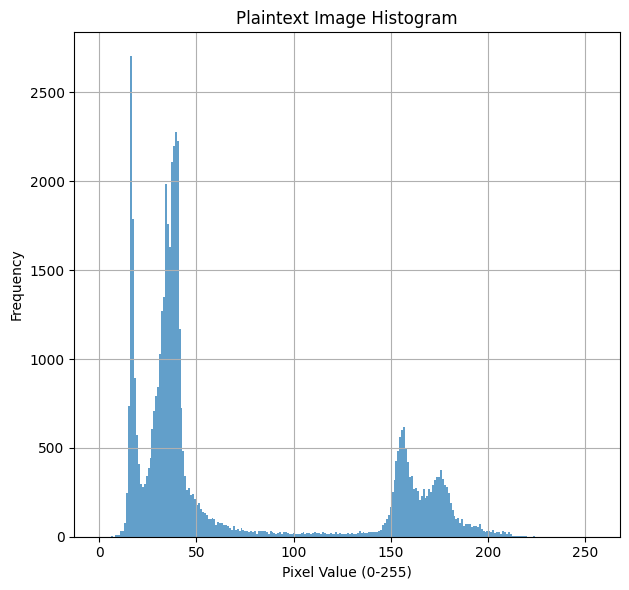

In [11]:
def original_histogram_analysis(plaintext_path: str):
    # Load image
    plaintext_img = Image.open(plaintext_path).convert('L')  # Convert to grayscale

    # Convert image to numpy array
    plaintext_data = np.array(plaintext_img).flatten()

    # Create figure with subplots
    plt.figure(figsize=(12, 6))

    # Plot histogram for plaintext image
    plt.subplot(1, 2, 1)
    plt.hist(plaintext_data, bins=256, range=(0, 255), alpha=0.7)
    plt.title("Plaintext Image Histogram")
    plt.xlabel("Pixel Value (0-255)")
    plt.ylabel("Frequency")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

original_histogram_analysis(original_image_path)

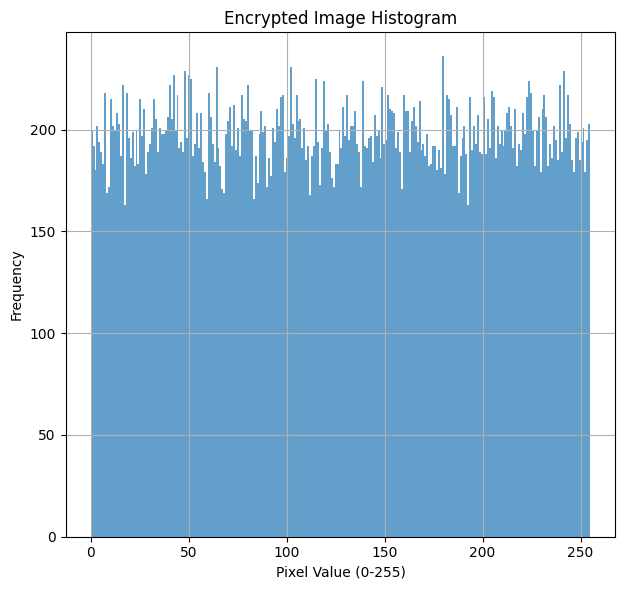

In [12]:
def encrypted_histogram_analysis(encrypted_path: str):
    # Load image
    encrypted_img = Image.open(encrypted_path).convert('L')  # Convert to grayscale

    # Convert image to numpy array
    encrypted_data = np.array(encrypted_img).flatten()

    # Create figure with subplots
    plt.figure(figsize=(12, 6))

    # Plot histogram for encrypted image
    plt.subplot(1, 2, 2)
    plt.hist(encrypted_data, bins=256, range=(0, 255), alpha=0.7)
    plt.title("Encrypted Image Histogram")
    plt.xlabel("Pixel Value (0-255)")
    plt.ylabel("Frequency")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

encrypted_histogram_analysis(encrypted_image_path)

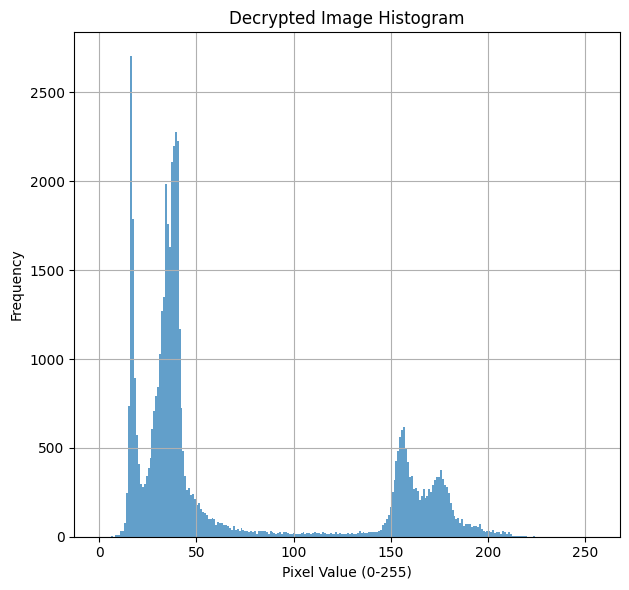

In [13]:
def decrypted_histogram_analysis(decrypted_path: str):
    # Load image
    decrypted_img = Image.open(decrypted_path).convert('L')

    # Convert image to numpy array
    decrypted_data = np.array(decrypted_img).flatten()

    # Create figure with subplots
    plt.figure(figsize=(12, 6))

    # Plot histogram for decrypted image
    plt.subplot(1, 2, 2)
    plt.hist(decrypted_data, bins=256, range=(0, 255), alpha=0.7)
    plt.title("Decrypted Image Histogram")
    plt.xlabel("Pixel Value (0-255)")
    plt.ylabel("Frequency")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

decrypted_histogram_analysis(decrypted_image_path)

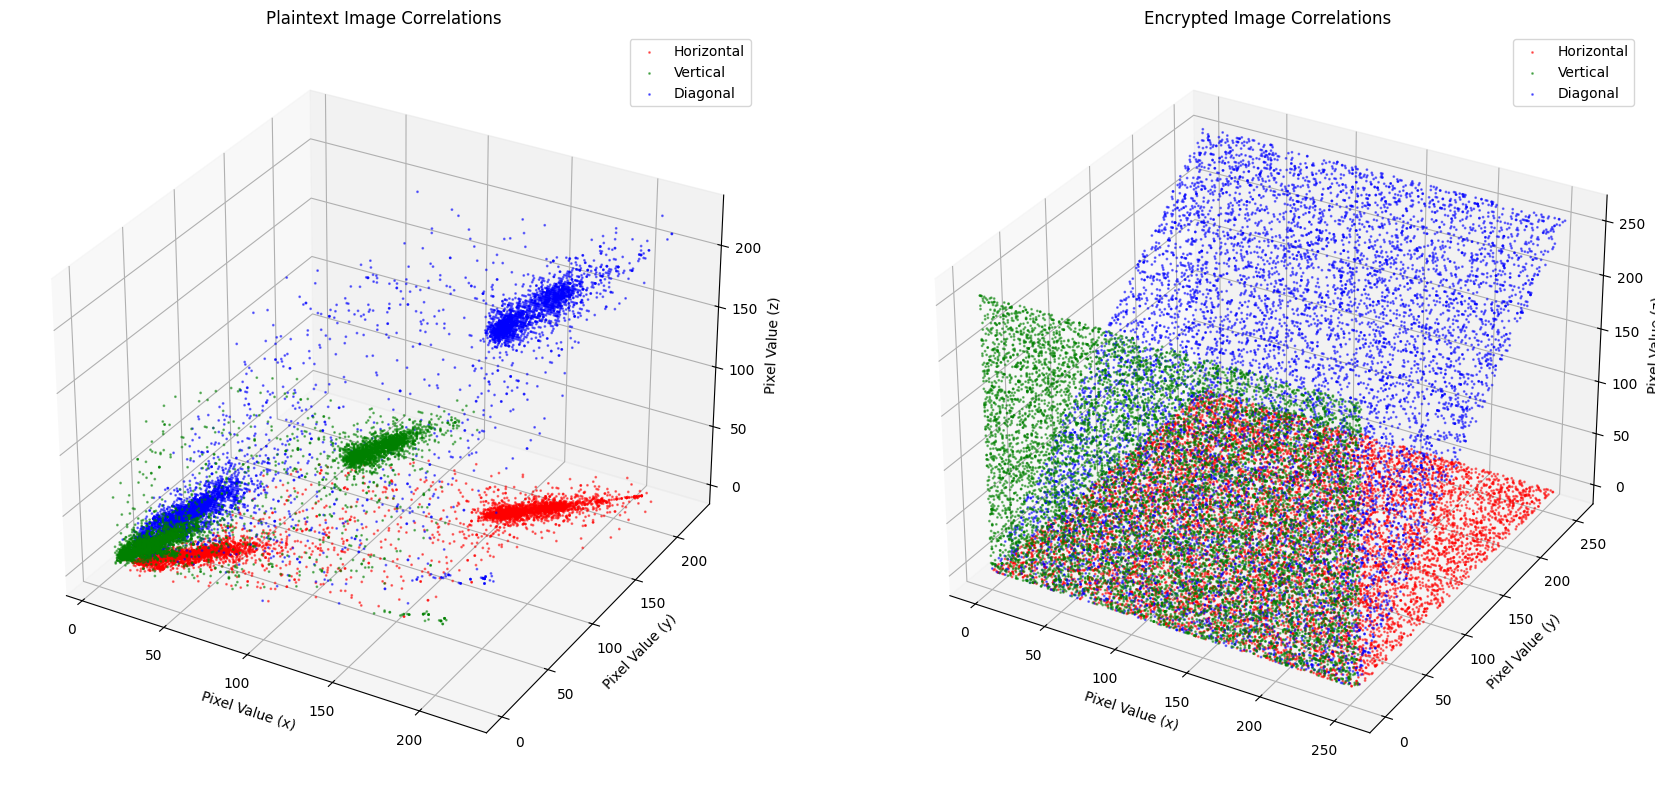

In [14]:
from mpl_toolkits.mplot3d import Axes3D

def get_correlation_data(image_data, height, width, num_pairs=10000):
    """
    Calculate horizontal, vertical, and diagonal pixel correlations.
    """
    def get_pairs(direction):
        pairs = []
        for _ in range(num_pairs):
            i = np.random.randint(0, height - 1)
            j = np.random.randint(0, width - 1)
            if direction == 'horizontal':
                pairs.append((image_data[i, j], image_data[i, j + 1]))
            elif direction == 'vertical':
                pairs.append((image_data[i, j], image_data[i + 1, j]))
            elif direction == 'diagonal':
                pairs.append((image_data[i, j], image_data[i + 1, j + 1]))
        return np.array(pairs)

    return {
        'horizontal': get_pairs('horizontal'),
        'vertical': get_pairs('vertical'),
        'diagonal': get_pairs('diagonal')
    }

def plot_3d_correlation_analysis(plaintext_path: str, encrypted_path: str):
    """
    Plot 3D correlation analysis for plaintext and encrypted images.
    """
    # Load images and convert to grayscale
    plaintext_img = Image.open(plaintext_path).convert('L')
    encrypted_img = Image.open(encrypted_path).convert('L')

    # Convert images to numpy arrays
    plaintext_data = np.array(plaintext_img)
    encrypted_data = np.array(encrypted_img)

    height, width = plaintext_data.shape

    # Get correlation data for plaintext and encrypted images
    plaintext_corr = get_correlation_data(plaintext_data, height, width)
    encrypted_corr = get_correlation_data(encrypted_data, height, width)

    # Create 3D plots
    fig = plt.figure(figsize=(18, 8))

    # Plot plaintext image correlations
    ax1 = fig.add_subplot(121, projection='3d')
    _plot_3d_correlations(ax1, plaintext_corr, "Plaintext Image Correlations")

    # Plot encrypted image correlations
    ax2 = fig.add_subplot(122, projection='3d')
    _plot_3d_correlations(ax2, encrypted_corr, "Encrypted Image Correlations")

    plt.tight_layout()
    plt.show()

def _plot_3d_correlations(ax, corr_data, title):
    """
    Plot 3D scatter plot for horizontal, vertical, and diagonal correlations.
    """
    # Extract data
    h = corr_data['horizontal']
    v = corr_data['vertical']
    d = corr_data['diagonal']

    # Plot horizontal correlations
    ax.scatter(h[:, 0], h[:, 1], np.zeros_like(h[:, 0]), c='r', label='Horizontal', s=1, alpha=0.5)

    # Plot vertical correlations
    ax.scatter(v[:, 0], np.zeros_like(v[:, 0]), v[:, 1], c='g', label='Vertical', s=1, alpha=0.5)

    # Plot diagonal correlations
    ax.scatter(d[:, 0], d[:, 1], d[:, 1], c='b', label='Diagonal', s=1, alpha=0.5)

    # Add labels and title
    ax.set_xlabel('Pixel Value (x)')
    ax.set_ylabel('Pixel Value (y)')
    ax.set_zlabel('Pixel Value (z)')
    ax.set_title(title)
    ax.legend()


plot_3d_correlation_analysis(original_image_path, encrypted_image_path)